StDek

added dendograme

changed the df.to_numeric code to one line. 

%%html
<style>
li{
  margin: 10px 0;
}
</style>
<h2>EDA Analysis Pipeline</h2>
Authors: Stephan, Yijoon, Hans, Frank

<h3>Index</h3>
<ol type="I">
<li><a href='#H1'>Defining the goal/problem</a></li>  
<li><a href='#H2'>Fetching and data sanitation</a></li>  
<li><a href='#section3'>Understand and visualize the data</a></li>
<li><a href='#section4'>Analyze the data</a></li>
<li><a href='#section5'>Interpret results</a></li>
<li><a href='#section6'>Iterate and refine</a></li>
<li><a href='#section7'>Save the data of your analysis</a></li>
</ol>

---
<a id='H1'></a>
## 1. Defining the goal/problem
```What is the purpose of this analysis?  ```

Building a model that accurately can predict the lifespan based on features in the data and use that to determine the premium for life insurance in an ethical way.

In [5]:
# all libraries required for the entire EDA

from requests import get
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Samuel Norman "Sam" Seaborn is a fictional character portrayed by Rob Lowe on the television serial drama The West Wing. Hence: sns
from seaborn_qqplot import pplot
import pandas as pd

import datetime as dt
from scipy import stats
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

import scipy.cluster.hierarchy as shc


%matplotlib inline
sns.set(color_codes=True)

---
<a id='H2'></a>
## 2. Fetching and data sanitation
```
- a. collect the data 
- b. check for: errors, missing values(Nan), data types(object,float,int), duplicates and other inconsistencies
- c. clean the data: remove duplicates and remove irrelevant information/columns
```

In [6]:
# for collecting data in csv form:
## ... WIP something to select the file you want to use. 

df_raw= pd.read_csv('../data/input_data/data.csv',skipinitialspace=True)

print(df_raw.head())
print()
print(df_raw.info())

  genetic length   mass exercise  smoking alcohol sugar  lifespan
0    73.9    185   99.7      0.9      0.0     2.4   6.9      73.1
1    86.0    172  105.4      1.8      8.1     0.4   4.2      85.0
2    83.3    176  111.4      1.1      0.8     4.6   7.5      81.6
3    82.8    164  111.4      4.7     11.8     1.0   2.9      81.0
4    78.7    178   71.6      1.5      8.3     4.9   5.5      75.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4096 non-null   object 
 1   length    4096 non-null   object 
 2   mass      4096 non-null   object 
 3   exercise  4096 non-null   object 
 4   smoking   4096 non-null   float64
 5   alcohol   4096 non-null   object 
 6   sugar     4096 non-null   object 
 7   lifespan  4096 non-null   float64
dtypes: float64(2), object(6)
memory usage: 256.1+ KB
None


In [7]:
# # for collecting data from REST API

# # Make request to an URL
# response = requests.get('http://localhost:8080/medish_centrum_randstad/api/netlify?page=1')

# file_contents= response.json()  #dictionary
# print(type(file_contents))
# print(len(file_contents))

# df = pd.DataFrame.from_dict(file_contents['data']) #all the needed info was condensed into one data column called 'data'
# display(df.head())
# display(df.shape)

In [8]:
df = df_raw.copy()

In [9]:
# ... select value to be looked at.

key = df.keys()

pipe = input('please type the name of the column you want to look at')
if pipe in key:
    print (f'We will be looking at "{pipe}" this time.')
else:
    print ('Please rerun this field and suply a valid column key.')

We will be looking at "mass" this time.


In [10]:
# # ... get a loc  not used atm
# dx=df.columns.get_loc(pipe)
# print (dx)

In [11]:
# ... removes turns non-int/non-flo to NaN and removes NaN
# ... selects if the columns have object as dtype. 
# ... Then chance the values in the columns to numbers and coerce tot NaN if the value cant be turned into a number. 

# the df will be the old df where we apply changed with a lambda to apply pd.to_numeric where non numbers will be coerced to NaN for those columns were dtype is object.  
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)

# ... change the dtype to float 64
df.astype('float64').dtypes


genetic     float64
length      float64
mass        float64
exercise    float64
smoking     float64
alcohol     float64
sugar       float64
lifespan    float64
dtype: object

Duplication Check

In [12]:
# ... a check to see if there are duplicates in the data.
# ... print the shape of the df
# ... report the duplicates and ask if you want the duplicates to be deleted. 

duplicate_rows_df = df[df.duplicated()]
print ("Number of duplicate rows: ", duplicate_rows_df.shape)

if duplicate_rows_df.shape == (0, 8):
    print ('There are no unexcpected duplicates')
else:
    print ('There are unexcpected duplicates please look at the data')
    print(duplicate_rows_df)
    x=input('Do you want to delete the duplicates? Y/n') 
    if x == 'Y':
        df=df.drop_duplicates()

Number of duplicate rows:  (0, 8)
There are no unexcpected duplicates


NaN-check

In [13]:
print(df.isnull().sum())


genetic     1
length      3
mass        2
exercise    1
smoking     0
alcohol     2
sugar       1
lifespan    0
dtype: int64


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4095 non-null   float64
 1   length    4093 non-null   float64
 2   mass      4094 non-null   float64
 3   exercise  4095 non-null   float64
 4   smoking   4096 non-null   float64
 5   alcohol   4094 non-null   float64
 6   sugar     4095 non-null   float64
 7   lifespan  4096 non-null   float64
dtypes: float64(8)
memory usage: 256.1 KB


In [15]:
# #...why is it missing, is it random? : input (impute) or delete? (some decisions come later outlier analysis, but some can be taken now)
# # ... future make a selector to remove NaN


df = df.dropna()

print(df.head())
print ()
print (df.info())

   genetic  length   mass  exercise  smoking  alcohol  sugar  lifespan
0     73.9   185.0   99.7       0.9      0.0      2.4    6.9      73.1
1     86.0   172.0  105.4       1.8      8.1      0.4    4.2      85.0
2     83.3   176.0  111.4       1.1      0.8      4.6    7.5      81.6
3     82.8   164.0  111.4       4.7     11.8      1.0    2.9      81.0
4     78.7   178.0   71.6       1.5      8.3      4.9    5.5      75.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4086 non-null   float64
 1   length    4086 non-null   float64
 2   mass      4086 non-null   float64
 3   exercise  4086 non-null   float64
 4   smoking   4086 non-null   float64
 5   alcohol   4086 non-null   float64
 6   sugar     4086 non-null   float64
 7   lifespan  4086 non-null   float64
dtypes: float64(8)
memory usage: 287.3 KB
None


Check for special characters ??/>, delete and convert to int/float etc.

---
<a id='section3'></a>
## 3. Understand and visualize the data
```
- a. Examine structure and content: size,shape and type of variables
- b. Theres great value of simply looking at the data: interquartile range, mean, median etc.
- c. Visualize the data with plots: histograms, box plots, scatter plots and heatmaps
- d. Identify any outliers, patterns, relationships or trends
- e. Decide to impute or delete the outliers
- f. Identify new features

```

Structure

In [16]:
print(df.head())

   genetic  length   mass  exercise  smoking  alcohol  sugar  lifespan
0     73.9   185.0   99.7       0.9      0.0      2.4    6.9      73.1
1     86.0   172.0  105.4       1.8      8.1      0.4    4.2      85.0
2     83.3   176.0  111.4       1.1      0.8      4.6    7.5      81.6
3     82.8   164.0  111.4       4.7     11.8      1.0    2.9      81.0
4     78.7   178.0   71.6       1.5      8.3      4.9    5.5      75.0


In [17]:
print(df.dtypes)
print(df.describe()) #mean,sd, min,max

genetic     float64
length      float64
mass        float64
exercise    float64
smoking     float64
alcohol     float64
sugar       float64
lifespan    float64
dtype: object
           genetic       length         mass     exercise      smoking  \
count  4086.000000  4086.000000  4086.000000  4086.000000  4086.000000   
mean     82.280127   183.879344    92.273837     2.403353     9.812677   
std       7.440070    12.627470    25.800771     1.170593     6.919057   
min      63.900000   154.000000    50.000000     0.100000     0.000000   
25%      77.600000   175.000000    71.425000     1.500000     3.400000   
50%      81.800000   184.000000    89.500000     2.200000     9.500000   
75%      86.700000   193.000000   110.875000     3.200000    15.900000   
max     102.200000   214.000000   163.600000     5.500000    22.200000   

           alcohol        sugar     lifespan  
count  4086.000000  4086.000000  4086.000000  
mean      2.266006     6.484973    80.137959  
std       1.801020

Plots

In [18]:
#Quick Overall Graphical Overview (!warning, takes ~2min or more)
#g = sns.PairGrid(df)
#g.map(sns.lineplot)

/Users/stephandekker/miniconda3/envs/miw/lib/python3.10/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


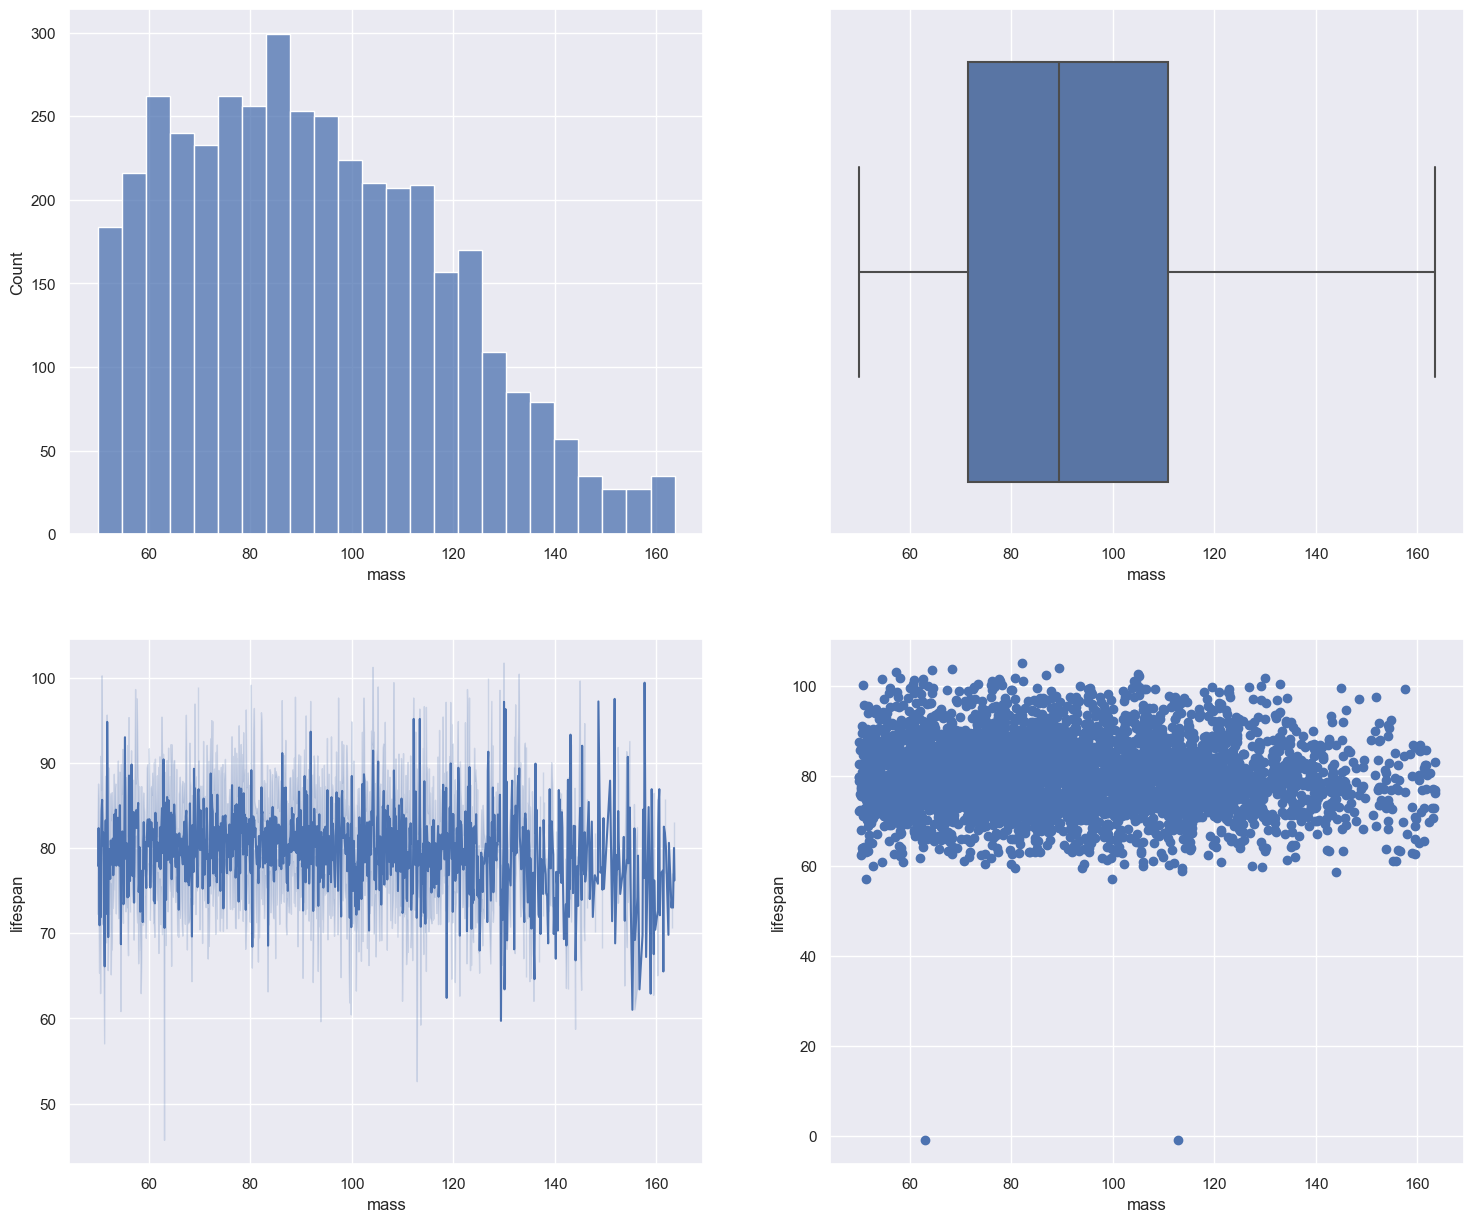

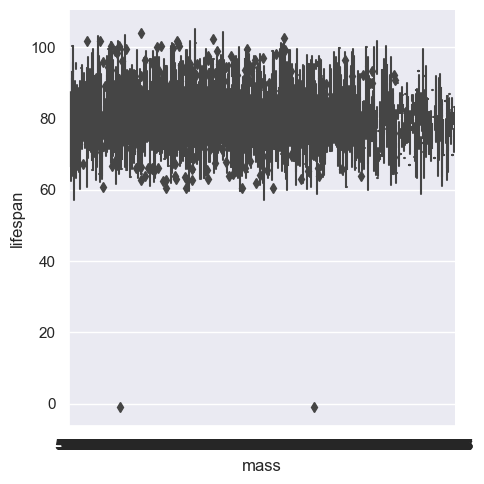

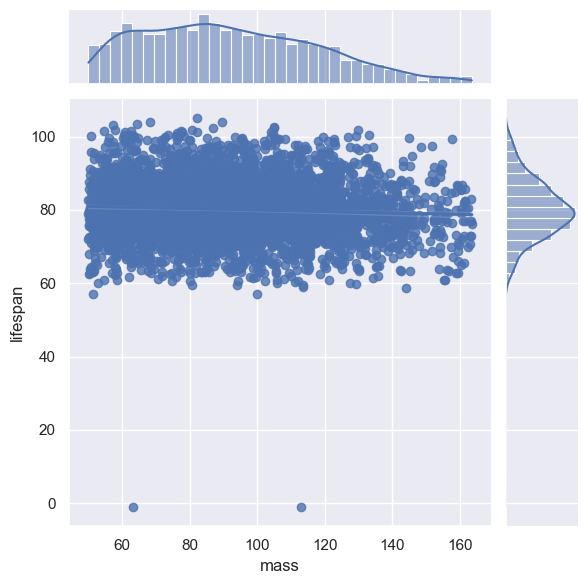

In [19]:
# Maak een raster voor 4 images

fig, axs = plt.subplots(2, 2, sharey=False, figsize=(18,15))

sns.boxplot(x=df[pipe], ax=axs[0,1])

axs[1][1].scatter(df[pipe], df['lifespan'])
axs[1][1].set_xlabel(pipe)
axs[1][1].set_ylabel('lifespan')

sns.lineplot(x=df[pipe],y=df['lifespan'], ax=axs[1,0])

sns.histplot(data=df,x=pipe, ax=axs[0,0])
sns.catplot(data=df, x=pipe, y='lifespan', kind='box', ax=axs[1,1])


#jointplot with distribution and regression line
sns.jointplot(data=df, x=pipe, y="lifespan",marginal_kws=dict(bins=35), kind='reg')
plt.show()


__[Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)__

$ \rho_{x,y} = \frac{cov(x,y)}{\sigma_{x}\sigma{y}}$


In [20]:
#colorfull matrix, showing correlations
df_corr = df.dropna().corr()
df_corr.style.background_gradient(cmap='RdBu')

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
genetic,1.000000,-0.030006,0.000654,-0.035257,-0.015208,-0.013323,0.018502,0.923706
length,-0.030006,1.000000,-0.000416,0.012258,-0.021369,-0.006838,0.008384,0.017464
mass,0.000654,-0.000416,1.000000,0.007632,-0.009469,0.000895,0.005904,-0.063538
exercise,-0.035257,0.012258,0.007632,1.000000,0.021186,-0.024523,-0.008367,0.081928
smoking,-0.015208,-0.021369,-0.009469,0.021186,1.000000,-0.012762,0.008103,-0.245163
alcohol,-0.013323,-0.006838,0.000895,-0.024523,-0.012762,1.000000,0.004664,-0.057211
sugar,0.018502,0.008384,0.005904,-0.008367,0.008103,0.004664,1.000000,-0.002425
lifespan,0.923706,0.017464,-0.063538,0.081928,-0.245163,-0.057211,-0.002425,1.000000


<AxesSubplot: >

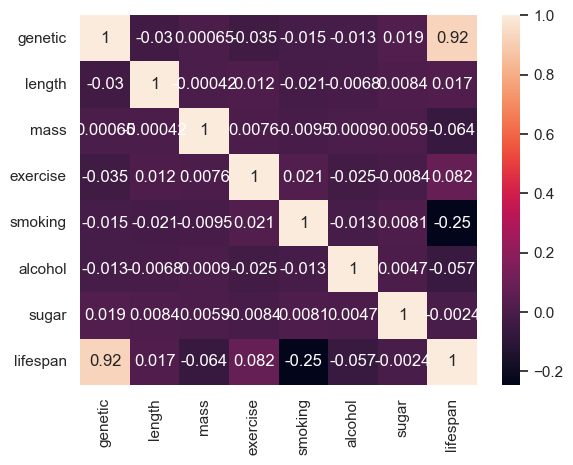

In [21]:
#graphical correlation matrix view
sns.heatmap(df_corr,annot=True)

Outliers: impute or delete?

<AxesSubplot: >

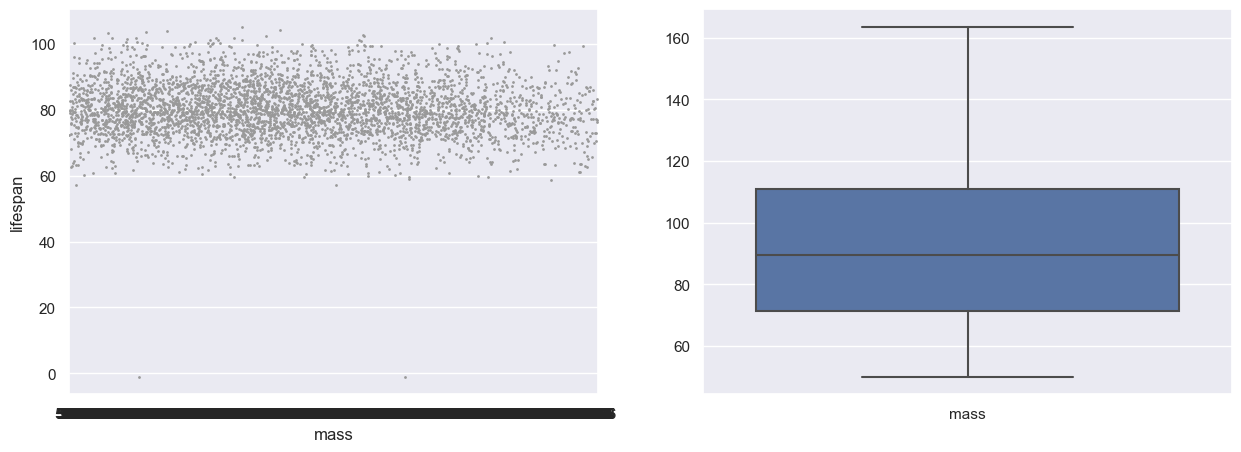

In [22]:
#Show stripplot, boxplot 
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.stripplot(df, x=pipe, y='lifespan',size=2, color=".6",ax=axes[0])
sns.boxplot(df[[pipe]],ax=axes[1])

<AxesSubplot: ylabel='mass'>

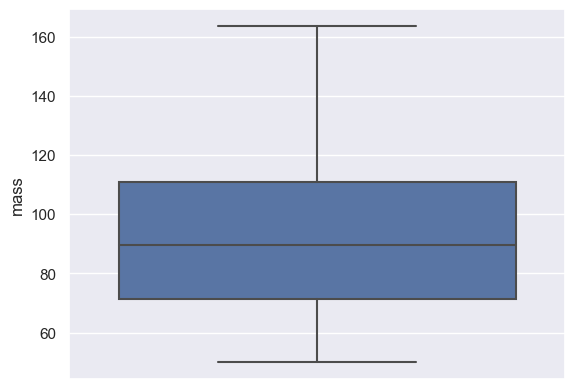

In [23]:
sns.boxplot(y=df[pipe])

In [24]:
#Q1=df['exercise'].quantile(0.25)
#print("Q1:", Q1)
#Q3=df['exercise'].quantile(0.75)
#print("Q3:", Q3)
#IQR=Q3-Q1
#print("IQR: ", IQR)
#lower_bound = Q1 - 1.5*IQR
#print("Lower Bound:", lower_bound)
#upper_bound = Q3 + 1.5*IQR
#print("Upper Bound:", upper_bound)

In [25]:
#df_clean = df[(df['exercise']>lower_bound)&(df['exercise']<upper_bound)]
#sns.boxplot(y = df_clean['exercise'])

# * Clean up outliers.

From boxplot we can check the outliers. I tried 2 ways to remove the outliers. One way is using IQR. The ohter way is using DBSCAN cluster. According to correlation gradient there were no differences in correlation.  Therefore outliers does not make any difference. I decided to keep the outliers.

DBSCAN, which stands for density-based spatial clustering of applications with noise, is an unsupervised clustering algorithm. This approach identifies any points that are loosely packed or sit alone outside of densely packed clusters as outliers.

In [26]:
X_train = df[[pipe,'lifespan']]
model = DBSCAN()
model.fit(X_train)

DBSCAN()

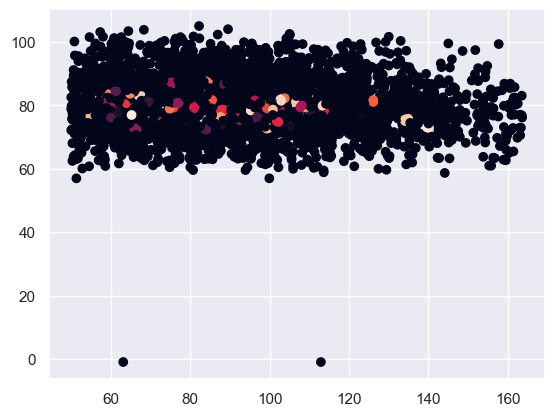

In [27]:
cluster_labels = model.labels_
plt.scatter(df[pipe], df["lifespan"], c = cluster_labels)
plt.show()

In [28]:
df['labels'] = cluster_labels
df_cluster_clean = df[df['labels'] != -1]

* Clean up outliers.

lifespan is highly correlated to exercise. IQR method and DBSCAN cluster method showed same result.
Therefore we will remove outliers for a variabel,'exercise'.

<AxesSubplot: xlabel='mass', ylabel='lifespan'>

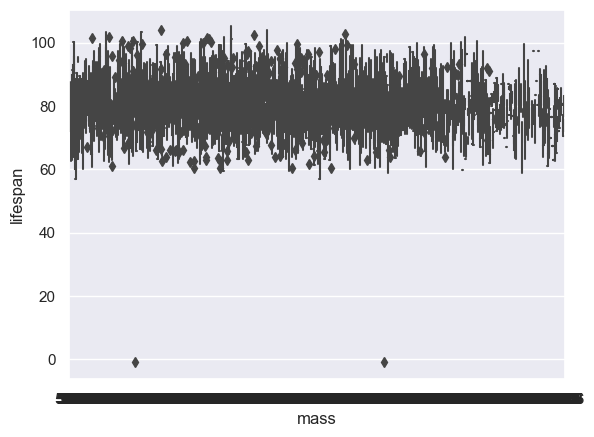

In [29]:
sns.boxplot(data=df, y= 'lifespan', x=pipe)

New features:


In [30]:
# New Feature BMI (kg/m^2)
# df['bmi'] = df['mass']/(df['length']/100)**2
# df.head()

# bmi_cats = [0, 18.5, 25, np.inf]
# labels_bmi_cats=['underweight','normal_range','overweight']
# df['bmi_cat']= pd.cut(df['bmi'], bins=bmi_cats, labels=labels_bmi_cats)

# bmi_subcats = [0, 16, 17, 18.5, 25, 30, 35, 40, np.inf]
# labels_bmi_subcats=['severe_thinness','moderate_thinness','mild_thinness','normal', 'pre_obese', 'obese_class_I', 'obese_class_II', 'obese_class_III']
# df['bmi_subcat']= pd.cut(df['bmi'], bins=bmi_subcats, labels=labels_bmi_subcats)


# df.head(12)

---
<a id='section4'></a>
## 4. Analyze the data
```
- a. Apply statistical analysis tools: mean, median, mode, standard deviation
- b. Go through Checklist for linear regression: normal distribution, continuous variable, correlation and p-value
- c  Apply regression
```

<li>Calculate P-values</li>

If p<0.05 (almost 0) the correlation for the feature is extremely likely to happen again if we collect more sample data and thus representative for the entire set


In [31]:
r,p = stats.pearsonr(df.lifespan,df[pipe])
print(f'{pipe} corr:',round(r,4))
print(f'{pipe} p-val:',round(p,4))

mass corr: -0.0635
mass p-val: 0.0


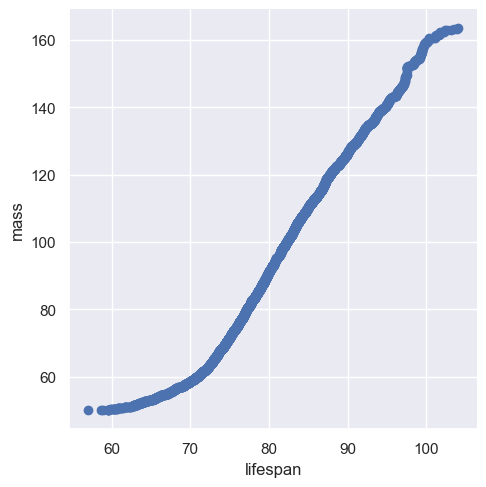

In [32]:
#Show Q-Q plot and draw conclusion on linearity and if linear regression is applicable 
from seaborn_qqplot import pplot
myplot = pplot(df, x="lifespan", y=pipe, kind='qq', height=5)

If the feature satisfies: 
 - continuous variable
 - correlation and it is linear-ish
 - normal-ish distributed 
 We can try to apply a linear regression method <br>
( e.g. in the form of
 $ y=\alpha*x_{smoking}+\beta*x_{exercise}+c $ )


In [33]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

X = train[[pipe, 'exercise']]
y = train.lifespan
regr = linear_model.LinearRegression()
regr.fit(X, y) 

LinearRegression()

In [34]:
# The coefficients
print('Coefficients: \n', regr.coef_)
print(f'c would be:',regr.predict([[0,0]]))

Coefficients: 
 [-0.02153135  0.52151418]
c would be: [80.84181503]


/Users/stephandekker/miniconda3/envs/miw/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In regression, the $R^{2}$ coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points.  <br>
Close to 1 means there is a strong correlation between the independent variables smoking, exercise and the dependent variable lifespan.

In [35]:
print(train.shape, test.shape)
score = regr.score(test[[pipe, 'exercise']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO}):', score)

(3268, 9) (818, 9)
coefficient of determination(R²): 0.015382562046726389


# This might need moving
```
- Use a dendograme to see if there are obvious clusters that need closer examining.  
```

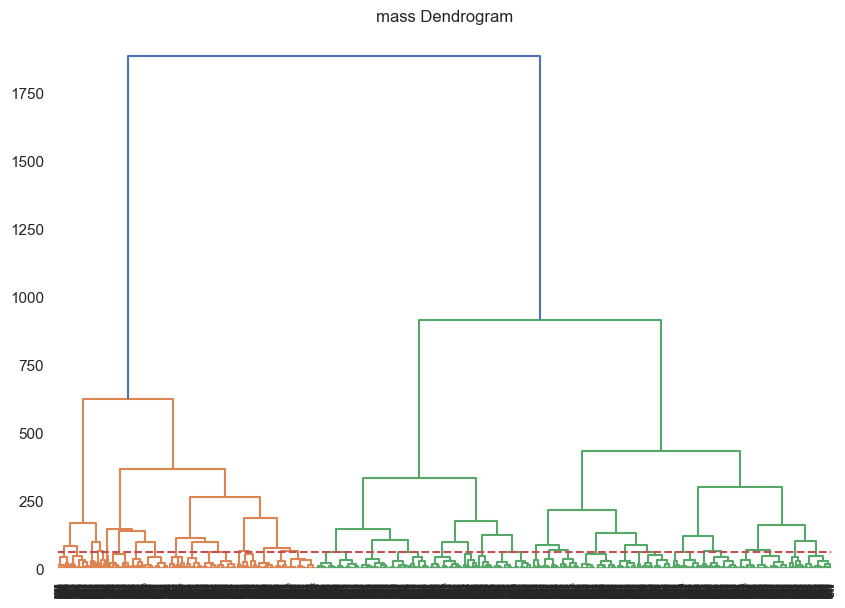

In [36]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title(f"{pipe} Dendrogram")

# Selecting lifespan to be compared with the pipe
selected_data = df.loc[:, ['lifespan',pipe]]
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)

# draw the line to make the picture clearer. Changing the value on the y axis can increase insight.
plt.axhline(y=65, color='r', linestyle='--')

plt.show()

---
<a id='section5'></a>
## 5. Interpret the results
```
- Draw conclusions, make insights and communicate in a clear, concise and unbiased manner
```

---
<a id='section6'></a>
## 6. Iterate and refine
```
- Explore alternative approaches e.g. test assumptions and update your conclusions based on feedback and new insights 
```

---
<a id='section7'></a>
## 7. Save the data of your analysis
```

In [37]:
# safe the data from this notebook as a csv in the folder output 

df.to_csv('../data/output_data/data_{}_{}.csv'.format(pipe,dt.datetime.now().strftime("%Y-%m-%d %H-%M")), index=False,sep=';')